In [1]:
import os
import sys

module_path = os.path.join(os.getcwd(), '../src')
sys.path.append(module_path)

import torch 
from gan_t2i.models.CLIP import CLIPModel
from gan_t2i.utils.model_loading import download_CLIP_model , CLIP_DATASETS


from gan_t2i.models.GAN import WGAN


from gan_t2i.datasets.DatasetFactory import DatasetFactory
import torchvision.transforms as transforms
import clip
from PIL import Image

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


# Loading data from checkpoints 

In [3]:
checkpoints_path = download_CLIP_model(CLIP_DATASETS.FLOWERS)

CLIP model FLOWERS already exits at c:\Users\Alex\Documents\GitHub\Deep-Learning-Final-Project\examples\models_weights\CLIP\CLIP~FT_FLOWERS\CLIP~FT_FLOWERS.pt


In [4]:
clip_model = CLIPModel.load(checkpoints_path)

Model loaded on device: cuda


------------------------------------

In [5]:
from torch.utils.data import DataLoader , SubsetRandomSampler

# Loading dataset

In [6]:
""" Text Transformation

You need to tokenize your text before passing it to the model.
"""
def tokenize_text(text):
    
    # Try except is needed due to error thrown by CLIP model that limit the context size
    # to 77 tokens so we need to split the text in smaller chunks and keep only a small portion
    # of it if the text is too long
    try:
        return clip.tokenize([text])[0]
    except:
        return clip.tokenize([text.split(".")[0]])[0]    
    

In [7]:
""" Image transformations """
transform_img = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    
    # Previously computed mean and std
    transforms.Normalize([0.4355, 0.3777, 0.2879], [0.2571, 0.2028, 0.2101])
])

In [8]:
dataset = DatasetFactory.Flowers(os.path.join(os.getcwd(), "..", "data"), transform_img=transform_img, transform_caption=tokenize_text)

Captions already downloaded
images already downloaded
Captions already extracted
images already extracted
The dataset is already stored in HDF5 format


In [9]:
# Create train, validation and test set     NOTE: We are using small subset of the dataset for this example
#      
# SMALL DATASET                                           This may and will cause overfitting this is only a demo
train_size = int(0.01 * len(dataset))       
val_size = int(0.01 * len(dataset))
test_size = int(0.02 * len(dataset))

print("train_size: {} , val_size: {} , test_size: {}".format(train_size,val_size,test_size))

# Cration of train, validation and test set indices and samplers
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, train_size + val_size + test_size))

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size=64
# Creation of train, validation and test dataloaders
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, pin_memory=True)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, pin_memory=True)

train_size: 818 , val_size: 818 , test_size: 1637


Min values : -1.8624260425567627  | Max Values : 3.389338731765747 | type : torch.float32


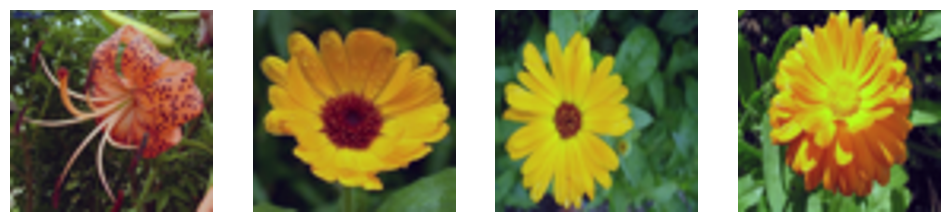

In [10]:
import matplotlib.pyplot as plt

def show_images(images, num_images=4):
    """
    Visualizza un set di immagini.

    Parameters:
        images (torch.Tensor): Le immagini da visualizzare. Devono avere forma (N, C, H, W).
        num_images (int): Il numero di immagini da visualizzare.
    """
    # Seleziona solo il numero di immagini specificato
    images = images[:num_images]

    # Cambia l'ordine dei canali da CHW a HWC per la visualizzazione
    images = images.permute(0, 2, 3, 1)  # (N, H, W, C)

    # Normalizza le immagini nel range [0, 1]
    images = (images - images.min()) / (images.max() - images.min())
    
    # Crea una figura per visualizzare le immagini
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for i in range(num_images):
        # Mostra l'immagine
        axs[i].imshow(images[i].cpu().detach().numpy())
        axs[i].axis('off')  # Nasconde gli assi per una visualizzazione più pulita

    plt.show()


for images, captions, _ in test_loader:  
   
    print("Min values : {}  | Max Values : {} | type : {}".format(images.min().item(),images.max().item(),images.dtype))
    show_images(images, num_images=4)  
    
    # Rompe il ciclo dopo il primo batch per facilitare la visualizzazione
    break


---------------------------------------

# Creating the GAN model and training it

- Get the image and text embedding 

In [11]:
# Per ottenere l'ultimo livello
dim_img_size , dim_text_size = clip_model.get_output_dimensions()
print("Cosa ritorna CLIP due vettori da: :", dim_img_size[1] , dim_text_size[1])

Cosa ritorna CLIP due vettori da: : 512 512


c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [12]:
embedding_size = dim_text_size[1]                     # dimensione di output quando codifico il testo con CLIP 
p_emb_dim = 128
WGAN_model = WGAN(clip_model,embedding_size,p_emb_dim)

print("Alla classe WGAN viene passato il modello di CLIP gia addestrato da prima sul dataset Flower e due dimensioni (output di clip = {}, proiezione = {})".format(embedding_size,p_emb_dim))


Alla classe WGAN viene passato il modello di CLIP gia addestrato da prima sul dataset Flower e due dimensioni (output di clip = 512, proiezione = 128)


In [18]:
checkpoints_path = os.path.join(os.getcwd(), "checkpoints")

WGAN_model.fit(
    train_dataloader = train_loader, 
    val_dataloader = val_loader,
    num_epochs = 3, 
    save_path=checkpoints_path
)

Checkpoints are present in 'c:\Users\Alex\Documents\GitHub\Deep-Learning-Final-Project\examples\checkpoints', training will start from epoch 0
Training on device: cuda


Epoch [1/3] Batch [13/13] Generator loss: -0.404180 | Discriminator loss: 0.794252: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch [1/3] Summary:
	=> Train Generator Loss: -0.404180
	=> Train Discriminator Loss: 0.794252


Validation [13/13] - Generator loss: 0.511097 | Discriminator loss: 0.088084: 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


	=> Validation Generator Loss: 0.511097
	=> Validation Discriminator Loss: 0.088084


Epoch [2/3] Batch [13/13] Generator loss: -0.405577 | Discriminator loss: 0.781814: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [2/3] Summary:
	=> Train Generator Loss: -0.405577
	=> Train Discriminator Loss: 0.781814


Validation [13/13] - Generator loss: 0.522415 | Discriminator loss: 0.142295: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


	=> Validation Generator Loss: 0.522415
	=> Validation Discriminator Loss: 0.142295


Epoch [3/3] Batch [13/13] Generator loss: -0.411367 | Discriminator loss: 0.777369: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch [3/3] Summary:
	=> Train Generator Loss: -0.411367
	=> Train Discriminator Loss: 0.777369


Validation [13/13] - Generator loss: 0.473236 | Discriminator loss: 0.152845: 100%|██████████| 13/13 [00:01<00:00,  7.45it/s]


	=> Validation Generator Loss: 0.473236
	=> Validation Discriminator Loss: 0.152845


----------------------------------------------------

# Load trained Model and predict an image based on the caption

In [14]:
checkpoints_full_path = os.path.join(os.getcwd(), "checkpoints/WGAN_epoch-1.pt") # choose your epoch
aux_model = WGAN(clip_model,embedding_size,p_emb_dim)
WGAN_model = aux_model.load(model_pt_filepath=checkpoints_full_path)

Checkpoint loaded for epoch 1.


generated_images shape torch.Size([64, 3, 64, 64]) 
Min values : -0.9999949932098389  | Max Values : 0.999678373336792 | type : torch.float32


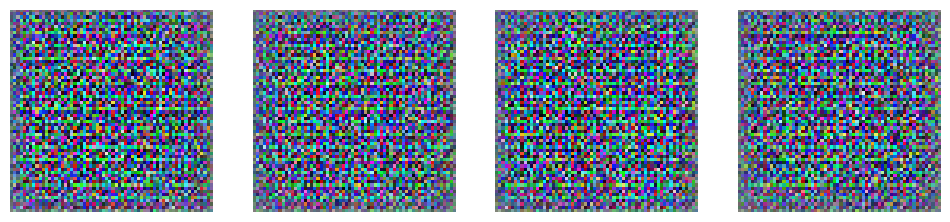

In [15]:
#for (images, captions, _) in test_loader:
for (images, captions, _) in train_loader:

    generated_images = WGAN_model.predict(captions)
    print("generated_images shape {} ".format(generated_images.shape))  # [256, 3, 224, 224]

    print("Min values : {}  | Max Values : {} | type : {}".format(generated_images.min().item(),generated_images.max().item(),generated_images.dtype))
    show_images(generated_images,num_images=4)

    break 

---------------------

# Load model from an epoch and start training from there 

In [16]:
checkpoints_full_path = os.path.join(os.getcwd(), "checkpoints/WGAN_epoch-3.pt")
aux_model = WGAN(clip_model,embedding_size,p_emb_dim)
WGAN_model = aux_model.load(model_pt_filepath=checkpoints_full_path)

Checkpoint loaded for epoch 3.


In [19]:
checkpoints_path = os.path.join(os.getcwd(), "checkpoints")

WGAN_model.fit(
    train_dataloader = train_loader, 
    val_dataloader = val_loader,
    num_epochs = 1, 
    save_path=checkpoints_path,
    starting_epoch = 3
)

Checkpoints are present in 'c:\Users\Alex\Documents\GitHub\Deep-Learning-Final-Project\examples\checkpoints', training will start from epoch 3
Training on device: cuda


Epoch [4/4] Batch [13/13] Generator loss: -0.407557 | Discriminator loss: 0.773079: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch [7/4] Summary:
	=> Train Generator Loss: -0.407557
	=> Train Discriminator Loss: 0.773079


Validation [13/13] - Generator loss: 0.499635 | Discriminator loss: 0.072753: 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


	=> Validation Generator Loss: 0.499635
	=> Validation Discriminator Loss: 0.072753
